### TODOs
- Adjust the object scoring function to:
    - score directly on the 3DObject class once it is created from Matcher
- Write a plotting function for ObjectInstance debugging

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import sys
from pathlib import Path
import matplotlib.pyplot as plt
import plotly.io as pio

# Ensure Plotly is set up to work with Jupyter notebooks
pio.renderers.default = 'notebook'

# Hack the path for now, deal with this later
cwd = '/teamspace/studios/this_studio/letsdoit'
if (cwd not in sys.path):
    sys.path.append(cwd)

from masks_finder import MasksFinder
from masks_matcher import MasksMatcher
from clip_retriever import ClipRetriever
from dataloader.dataloader import DataLoader
from object_scorer import ObjectScorer
from letsdoit.utils.object_instance import ObjectInstance, initialize_object_instances
from letsdoit.utils.misc import select_ids

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [3]:
path_dataset = '/teamspace/studios/this_studio/datasets'
ASSET_TYPE = 'wide'
loader = DataLoader(path_dataset, split='dev')
retriever = ClipRetriever()
masks_finder = MasksFinder()
visit_ids = loader.visit_ids
video_ids = loader.get_video_ids(visit_ids[0])

visit_id = visit_ids[0]
video_id = video_ids[0]
images, image_paths, intrinsics, poses, orientations = loader.get_images(visit_id, video_id, asset_type=ASSET_TYPE, sample_freq=1)
depths, depth_paths, _, _, _ = loader.get_depths(visit_id, video_id, asset_type=ASSET_TYPE, sample_freq=1)
retriever.generate_image_features(images)

final text_encoder_type: bert-base-uncased


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


_IncompatibleKeys(missing_keys=[], unexpected_keys=['label_enc.weight'])
<All keys matched successfully>


Loading rgb frames from visit 420683 and video 42445132: 100%|██████████| 159/159 [00:07<00:00, 20.43it/s]
Loading depth frames from visit 420683 and video 42445132: 100%|██████████| 159/159 [00:05<00:00, 30.39it/s]


In [4]:
# For an object, get a list of corresponding ObjectInstances
object = 'drawer'
best_indices = retriever.retrieve_best_images_for_object(object)
best_images = select_ids(images, best_indices)
best_image_paths = select_ids(image_paths, best_indices)
best_intrinsics = select_ids(intrinsics, best_indices)
best_poses = select_ids(poses, best_indices)
best_orientations = select_ids(orientations, best_indices)
best_depths = select_ids(depths, best_indices)
best_depth_paths = select_ids(depth_paths, best_indices)
image_ids, masks, bboxes, confidences, labels = masks_finder.get_masks_from_imgs(best_images, object)

  0%|          | 0/10 [00:00<?, ?it/s]/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/transformers/modeling_utils.py:768: FutureWarning:

The `device` argument is deprecated and will be removed in v5 of Transformers.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/checkpoint.py:460: UserWarning:

torch.utils.checkpoint: please pass in use_reentrant=True or use_reentrant=False explicitly. The default value of use_reentrant will be updated to be False in the future. To maintain current behavior, pass use_reentrant=True. It is recommended that you use use_reentrant=False. Refer to docs for more details on the differences between the two variants.

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/torch/utils/checkpoint.py:90: UserWarning:

None of the inputs have requires_grad=True. Gradients will be None

100%|██████████| 10/10 [00:12<00:00,  1.27s/it]


In [5]:
dict_object_instances = {'images': select_ids(best_images, image_ids),
                         'depths': select_ids(best_depths, image_ids),
                         'bboxes': bboxes,
                         'masks': masks,
                         'labels': labels,
                         'confidences': confidences,
                         'intrinsics': select_ids(best_intrinsics, image_ids),
                         'extrinsics': select_ids(best_poses, image_ids),
                         'orientations': select_ids(best_orientations, image_ids)}

object_instances = initialize_object_instances(**dict_object_instances)

In [6]:
# Plot mask 2D (easy, just copy previous code)
# Plot mask 3D (harder, plot mask projection to world's coordinates using depth)
obj = object_instances[0]

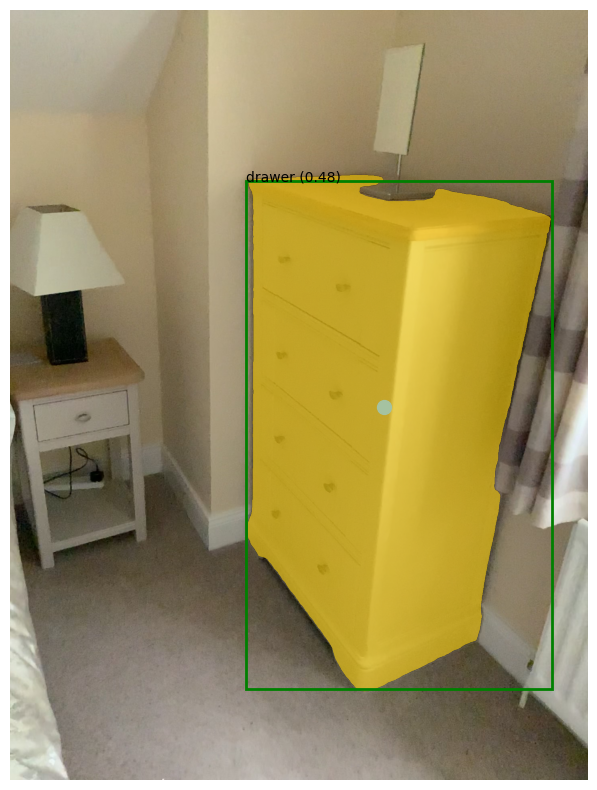

In [7]:
obj.plot_2d()

In [8]:
obj.plot_3d()

KeyboardInterrupt: 